# **CS 1810 Homework 2**
---
To account for potential version issues, try the following in your terminal:

1. Create a new environment with `python3 -m venv venv`
2. Activate that environment with `source venv/bin/activate`
3. Make sure the interpreter in the top right corner of your VSCode (or whatever you use to run your code is venv).
4. If you get a "install kernel" message, press it.
5. Run `pip install -r requirements.txt`
6. Run the remainder of this notebook.

Note that this is not necessary but can help prevent any issues due to package versions.

**The following notebook is meant to help you work through Problems 1 and 3 on Homework 2. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/cs1810/hw2
!ls  # confirm the file T2_P1_TestCases.py or folder is here

Mounted at /content/drive
/content/drive/MyDrive/cs1810/hw2
data	   hw2.pdf  img_input	__pycache__	  T2_P1_TestCases.py
hw2.ipynb  hw2.tex  img_output	requirements.txt  T2_P3_TestCases.py


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as c
import matplotlib.patches as mpatches
from scipy.special import expit as sigmoid
from scipy.special import softmax
from scipy.special import logsumexp
from scipy.stats import multivariate_normal as mvn
from T2_P1_TestCases import test_p1
from T2_P3_TestCases import test_p3_softmax, test_p3_knn

In [41]:
### Data for Problem 1
t_obs, y_obs = np.genfromtxt("data/planet-obs.csv", delimiter = ',').T
t_obs = np.split(t_obs, 10)
y_obs = np.split(y_obs.reshape(-1, 1), 10)

### Data for Problem 3
data = pd.read_csv("data/hr.csv")
mapper = {
    "Automatically Rejected": 0,
    "Require Guarantor": 1,
    "Automatically Accepted": 2
}
data['Type'] = data['Type'].map(mapper)
X_applicants = data[['Debt to Income Ratio', 'Credit Score']].values

# transformation as described in problem statement
def transform(X):
  X = np.stack((X[:,0]*20/0.7-7.5, X[:,1]/140 - (500/140+0.5)), axis=1)
  return X
# Transformation
X_applicants = transform(X_applicants)
y_applicants = data['Type'].values

In [42]:
# for alternate obs
alternate = pd.read_csv("data/planet-obs-alternate.csv", index_col="Unnamed: 0")
t_obs_alt, y_obs_alt = alternate[["# Time", " Observed"]].values.T
t_obs_alt = np.split(t_obs_alt, 10)
y_obs_alt = np.split(y_obs_alt.reshape(-1, 1), 10)

# Problem 1

## Problem 1 Subpart 1

In [15]:
def basis1(t):
    return np.stack([np.ones(len(t)), t], axis=1)

def basis2(t):
    """
    Transform t into basis [1, t, t^2]

    :param t: a numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 3)
    """
    return np.stack([
        np.ones(len(t)),
        t,
        t**2
    ], axis=1)

def basis3(t):
    """
    Transform t into basis [1, t, t^2, t^3, t^4, t^5]

    :param t: a numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 6)
    """
    return np.stack([
        np.ones(len(t)),
        t,
        t**2,
        t**3,
        t**4,
        t**5
    ], axis=1)


In [16]:
class LogisticRegressor:
    def __init__(self, eta, runs):
        self.eta = eta
        self.runs = runs
        self.W = None

    def fit(self, x, y, w_init):
        """
        Optimize the weights W to minimize the negative log-likelihood by using gradient descent

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :param y: a 2D numpy array of output values. Shape is (n x 1)
        :param w_init: a 2D numpy array that initializes the weights. Shape is (d x 1)
        :return: None
        """
        # Keep this for the autograder
        self.W = w_init
        for _ in range(self.runs):
          y_hat = sigmoid(np.inner(self.W.T, x)).reshape(-1,1)
          self.W -= self.eta * np.sum((y_hat-y)*x, axis=0).reshape(-1,1)

    def predict(self, x):
        """
        Predict classification probability of transformed input x

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :return: a 2D numpy array of predicted probabilities given current weights. Shape should be (n x 1)
        """
        # require: model is already fitted
        return sigmoid(np.inner(self.W.T, x)).reshape(-1,1)

In [ ]:
test_p1(LogisticRegressor, basis1, basis2, basis3)

2.000020757104268
Your test case results are, for basis 1, 2, and 3 respectively: Fail Fail Fail


Note: Students have reported local issues with passing the basis 3 test case. Try running on Google Colab if only basis 3 test is failing.  

## Plotting Functions for Problem 1, Subpart 2

In [44]:
# Function to visualize prediction lines
# Takes as input last_x, last_y, [list of models], basis function, title
# last_x and last_y should specifically be the dataset that the last model
# in [list of models] was trained on
def visualize_prediction_lines(last_x, last_y, models, basis, title):
    # Plot setup
    green = mpatches.Patch(color='green', label='Ground truth model')
    black = mpatches.Patch(color='black', label='Mean of learned models')
    purple = mpatches.Patch(color='purple', label='Model learned from displayed dataset')
    plt.legend(handles=[green, black, purple], loc='lower right')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Observed')
    plt.axis([0, 6, -.1, 1.1]) # Plot ranges

    # Plot dataset that last model in models (models[-1]) was trained on
    cmap = c.ListedColormap(['r', 'b'])
    plt.scatter(last_x, last_y, c=last_y, cmap=cmap, linewidths=1, edgecolors='black')

    # Plot models
    X_pred = np.linspace(0, 6, 1000)
    X_pred_transformed = basis(X_pred)

    ## Ground truth model
    plt.plot(X_pred, np.cos(1.1*X_pred + 1) * 0.4 + 0.5, 'g', linewidth=5)

    ## Individual learned logistic regressor models
    Y_hats = []
    for i in range(len(models)):
        model = models[i]
        Y_hat = model.predict(X_pred_transformed)
        Y_hats.append(Y_hat)
        if i < len(models) - 1:
            plt.plot(X_pred, Y_hat, linewidth=.3)
        else: # this is the last individual dataset. arbitrarily chosen, just want to see what an individual subdataset looks like
            plt.plot(X_pred, Y_hat, 'purple', linewidth=3)

    # Mean / expectation of learned models over all datasets
    plt.plot(X_pred, np.mean(Y_hats, axis=0), 'k', linewidth=5)

    plt.savefig('img_output/' + title + '.png')
    plt.show()

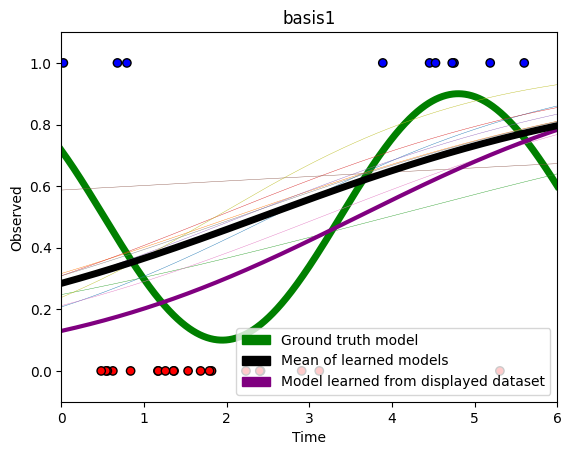

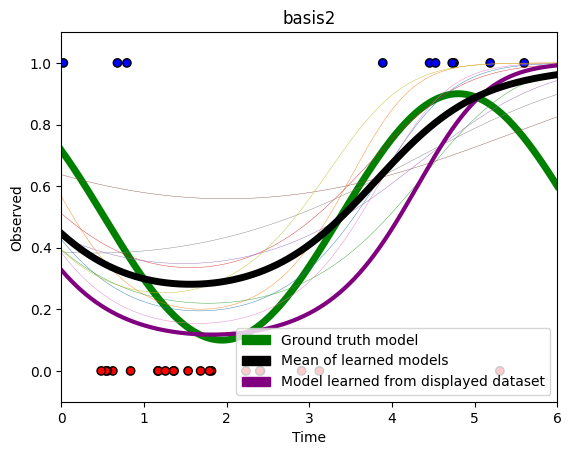

Classification probabilities for t = 0.1: 0.8109924190482568, t = 3.2: 1.0
Model variances for t = 0.1: 0.10602802103739584, t = 3.2: 0.24


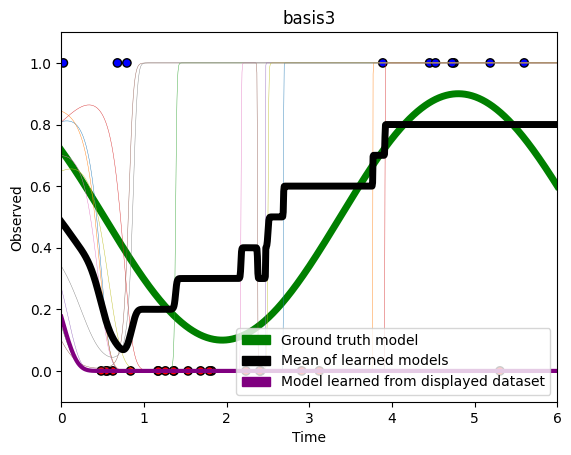

In [ ]:
def plot_results(basis, title):
    eta = 0.001
    runs = 1000

    # For Problem 1.4
    test_points_1 = []
    test_points_2 = []
    t1 = basis(np.array([0.1]))
    t2 = basis(np.array([3.2]))

    all_models = []
    for i in range(10):
        x, y = t_obs[i], y_obs[i]
        x_transformed = basis(x)
        model = LogisticRegressor(eta=eta, runs=runs)
        model.fit(x_transformed, y, np.zeros((x_transformed.shape[1], 1)))
        all_models.append(model)

        if basis == basis3:
            # extract values from (1 x 1) array
            pred_1 = model.predict(t1)[0, 0]
            pred_2 = model.predict(t2)[0, 0]
            if i == 0: # compute for the 1st model only
                print(f"Classification probabilities for t = 0.1: {pred_1}, t = 3.2: {pred_2}")
            test_points_1.append(pred_1)
            test_points_2.append(pred_2)

    if basis == basis3:
        print(f"Model variances for t = 0.1: {np.var(test_points_1)}, t = 3.2: {np.var(test_points_2)}")
    visualize_prediction_lines(x, y, all_models, basis, title)

plot_results(basis1, 'basis1')
plot_results(basis2, 'basis2')
plot_results(basis3, 'basis3')

# Problem 3

In [ ]:
class GaussianGenerativeModel:
    def __init__(self, is_shared_covariance=False):
        self.is_shared_covariance = is_shared_covariance

    def __get_mean_cov(self, X, y):
        # Returns the MLE values of Mu and Sigma
        self.K = len(np.unique(y))
        self.n = len(y)
        self.D = X.shape[1]

        mu = np.empty((0,self.D))
        sigma = np.empty((0,self.D,self.D))
        sigma_share = np.zeros((self.D,self.D))
        for k in range(self.K):
            indices = np.where(y==k)[0]
            class_ct = len(indices)

            mu_k = np.mean(X[indices],axis=0)
            sigma_k = np.mean( [np.outer(X[i]-mu_k,X[i]-mu_k) for i in indices], axis=0 )

            mu = np.vstack((mu, mu_k))
            sigma = np.vstack((sigma, sigma_k.reshape(1,self.D,self.D)))
            sigma_share += sigma_k * class_ct
        sigma_share /= self.n

        return mu, sigma, sigma_share

    def __get_prior(self, y):
        K = len(np.unique(y))
        self.class_cts = np.array([np.count_nonzero(y==k) for k in range(K)])
        n = len(y)
        return self.class_cts/n

    def __get_gaussian_likelihood(self, X, k):
        if self.is_shared_covariance:
            sigma = self.Sigma_share
        else:
            sigma = self.Sigma[k]
        return mvn.pdf(X, self.Mu[k], sigma)

    def __get_gaussian_posterior(self, X_pred, prior):
        posterior = np.empty((X_pred.shape[0], 0))
        for k in range(self.K):
            posterior = np.column_stack((posterior, prior[k] * self.__get_gaussian_likelihood(X_pred, k)))
        return posterior / posterior.sum(axis=1, keepdims=True)

    def fit(self, X, y):
        """
        Compute the means and (shared) covariance matrix of the data. Compute the prior over y.

        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
        :return: None
        """
        self.Mu, self.Sigma, self.Sigma_share = self.__get_mean_cov(X,y)
        self.pi = self.__get_prior(y)

    def predict(self, X_pred):
        """
        Predict classes of points given feature values in X_pred

        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
                 Shape should be (n,)
        """
        return np.argmax(self.predict_proba(X_pred), axis=1)

    def predict_proba(self, X_pred):
        # we know that p(y_i = C_k | x_i) = p(y_i = C_k, x_i) / prior(x_i) \propto p(y_i = C_k, x_i)
        # require: model already been fitted with X,y
        return self.__get_gaussian_posterior(X_pred, self.pi)

    def negative_log_likelihood(self, X, y):
        """
        Given the data X, use previously calculated class means and covariance matrix to
        calculate the negative log likelihood of the data
        """
        self.fit(X,y)
        gaussian_component, prior_component = 0, 0
        for k in range(self.K):
            indices = np.where(y==k)[0]
            gaussian_component += np.sum(np.log(self.__get_gaussian_likelihood(X[indices],k)))
            prior_component += np.log(self.pi[k]) * self.class_cts[k]

        return -(gaussian_component + prior_component)


In [5]:
class SoftmaxRegression:
    def __init__(self, eta, lam, verbose=True):
        self.eta = eta
        self.lam = lam
        self.W = None
        self.verbose = verbose # TODO: WHAT IS VERBOSE?
        self.MAX_ITERATIONS = 200000

    def __get_gradient(self, X, y):
        y_hat = softmax(np.inner(X, self.W), axis=1)
        y = np.eye(self.K)[y]
        return np.inner((y_hat-y).T, X.T)

    def __get_cross_entropy(self, X, y, regularized=True):
        gradient = self.__get_gradient(X,y)
        if not regularized:
            return gradient
        reg = np.zeros_like(self.W)
        reg[:,1:] = self.lam * self.W[:,1:]
        return gradient + reg

    def fit(self, X, y):
        """
        Fit the weights W of softmax regression using gradient descent with L2 regularization

        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
        :return: None
        """
        X = np.column_stack((np.ones(X.shape[0]), X))
        self.D = X.shape[1]
        self.K = len(np.unique(y))
        self.W = np.ones((self.K, self.D))
        for _ in range(self.MAX_ITERATIONS):
            self.W -= self.eta * self.__get_cross_entropy(X,y)
        return

    # Input is (n x 2) array
    def predict(self, X_pred):
        """
        Predict classes of points given feature values in X_pred

        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
                 Shape should be (n,)
        """
        return np.argmax(self.predict_proba(X_pred), axis=1)

    # Input is (n x 2) array
    def predict_proba(self, X_pred):
        """
        Predict classification probabilities of points given feature values in X_pred

        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 2D numpy array of predicted class probabilities (Automatically Rejected=index 0, Require Guarantor=index 1, Automatically Accepted=index 2).
                 Shape should be (n x 3)
        """
        X_pred = np.column_stack((np.ones(X_pred.shape[0]), X_pred))
        return softmax(np.inner(self.W, X_pred).T, axis=1)

In [12]:
class KNNClassifier:
    def __init__(self, k):
        self.X = None
        self.y = None
        self.K = k

    def __get_dist(self, a, b, axis=0):
        diff = a - b
        diff[:,:,0] /= 3
        return np.sqrt(np.sum(diff**2, axis=axis))

    def __get_most_common(self, y_k):
        counts = np.apply_along_axis(lambda x: np.bincount(x, minlength=self.num_classes), axis=1, arr=y_k)
        return np.apply_along_axis(lambda x: np.random.choice(np.where(x==x.max())[0]), axis=1, arr=counts)

    def fit(self, X, y):
        """
        In KNN, "fitting" can be as simple as storing the data, so this has been written for you.
        If you'd like to add some preprocessing here without changing the inputs, feel free,
        but this is completely optional.
        """
        self.X = X
        self.y = y
        self.num_classes = len(np.unique(y))

    def predict(self, X_pred_many):
        """
        Predict classes of points given feature values in X_pred

        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
                 Shape should be (n,)
        """
        n_pred, D = X_pred_many.shape
        n = self.X.shape[0]
        dists = self.__get_dist(X_pred_many.reshape(n_pred,1,D), self.X.reshape(1,n,D), axis=2)
        indices = np.argsort(dists, axis=1)[:, :self.K]

        y_k = self.y[indices]  # k-nearest neighbors

        return self.__get_most_common(y_k)

In [6]:
def phi(X):
    """
    Transform [x_1, x_2] into basis [ln(x_1 + 10), x_2^2]

    :param X: a 2D numpy array of values to transform. Shape is (n x 2)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 2)
    """
    x1, x2 = X.T
    phi_x1 = np.vectorize(lambda x: np.log(x + 10))(x1)
    phi_x2 = np.vectorize(lambda x: x**2)(x2)
    return np.vstack((phi_x1,phi_x2)).T

## Plotting Function for Problem 3, Subpart 1

In [7]:
# Visualize the decision boundary that a model produces
def visualize_boundary(model, X, y, title, basis=None, width=10):
    # Create a grid of points
    x_min, x_max = min(X[:, 0]-width*0.15), max(X[:, 0]+width*0.15)
    y_min, y_max = min(X[:, 1]-width*0.2), max(X[:, 1]+width*0.2)
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.05),
        np.arange(y_min, y_max, 0.05)
    )

    # Flatten the grid so the values match spec for self.predict
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    X_pred = np.vstack((xx_flat, yy_flat)).T

    if basis is not None:
        X_pred = basis(X_pred)

    # Get the class predictions
    Y_hat = model.predict(X_pred)
    Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))

    # Visualize them.
    cmap = c.ListedColormap(['r', 'b', 'g'])
    plt.figure()
    plt.title(title)
    plt.xlabel('Debt to Income Ratio')
    plt.ylabel('Credit Score')

    ticks = np.transpose(np.array([[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
                                   [300, 400, 500, 600, 700, 800, 900, 1000]]))
    transformed_ticks = transform(ticks)


    plt.xticks(transformed_ticks[:,0],
               ticks[:,0])
    plt.yticks(transformed_ticks[:,1],
               ticks[:,1])
    plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, linewidths=1,
                edgecolors='black')

    # Adding a legend and a title
    red = mpatches.Patch(color='red', label='Automatically Rejected')
    blue = mpatches.Patch(color='blue', label='Require Guarantor')
    green = mpatches.Patch(color='green', label='Automatically Accepted')
    plt.legend(handles=[red, blue, green])

    # Saving the image to a file, and showing it as well
    plt.savefig('img_output/' + title + '.png')
    plt.show()

## Problem 3, Subpart 1

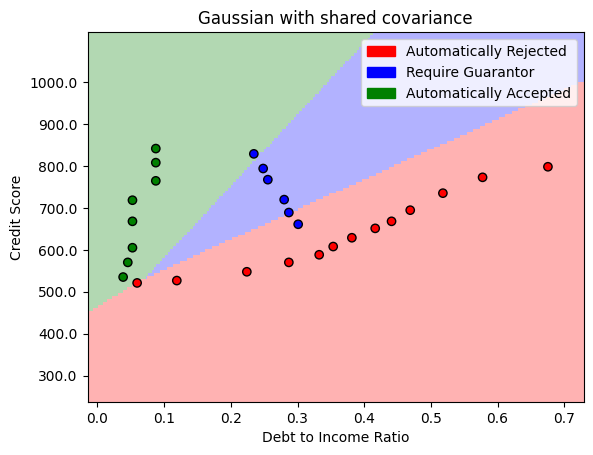

In [ ]:
# shared
gaussian_shared = GaussianGenerativeModel(True)
gaussian_shared.fit(X_applicants, y_applicants)
visualize_boundary(
    gaussian_shared,
    X_applicants,
    y_applicants,
    "Gaussian with shared covariance"
)

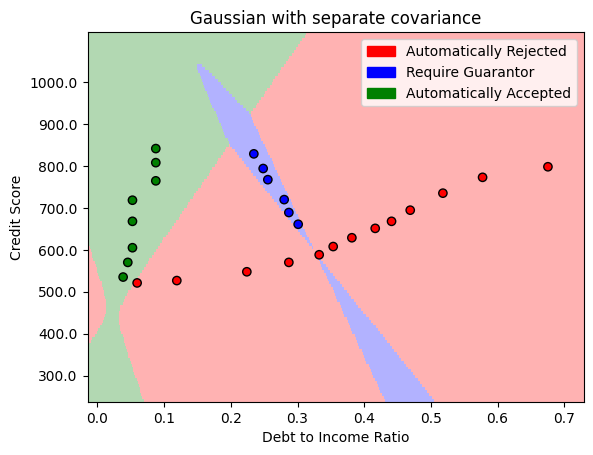

In [ ]:
# separate covariance
gaussian_separate = GaussianGenerativeModel(False)
gaussian_separate.fit(X_applicants, y_applicants)
visualize_boundary(
    gaussian_separate,
    X_applicants,
    y_applicants,
    "Gaussian with separate covariance"
)

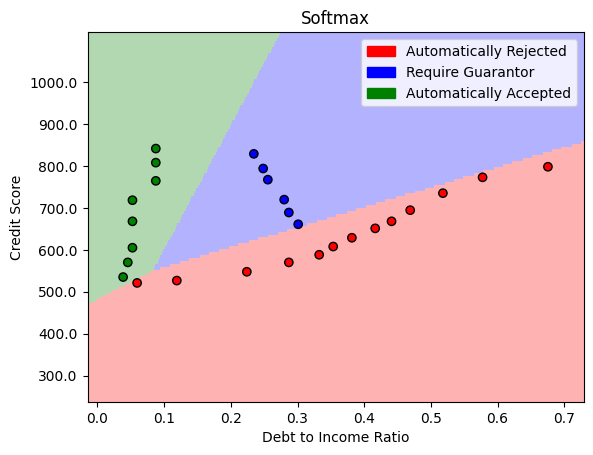

In [ ]:
# softmax
soft = SoftmaxRegression(0.001, 0.001)
soft.fit(X_applicants, y_applicants)
visualize_boundary(
    soft,
    X_applicants,
    y_applicants,
    "Softmax"
)

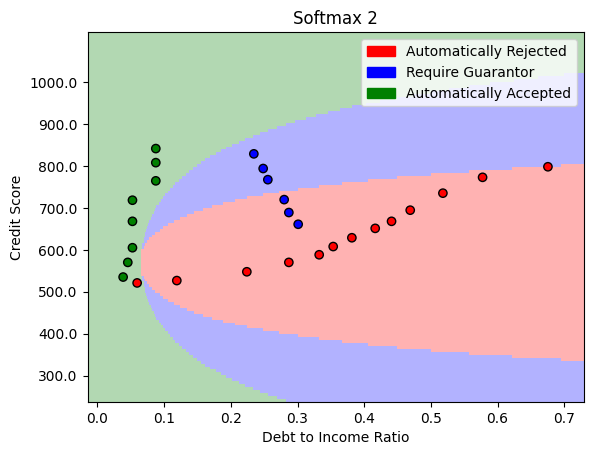

In [11]:
# second multi-class logistic regression classifier
soft2 = SoftmaxRegression(0.001, 0.001)
soft2.fit(phi(X_applicants), y_applicants)
visualize_boundary(
    soft2,
    X_applicants,
    y_applicants,
    "Softmax 2",
    basis=phi
)

<ipython-input-135-34d918e964e2>:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('img_output/' + title + '.png')


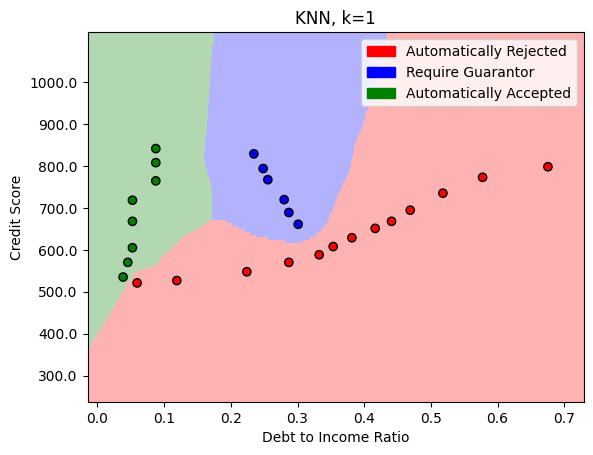

In [ ]:
# k=1
knn1 = KNNClassifier(1)
knn1.fit(X_applicants, y_applicants)
visualize_boundary(
    knn1,
    X_applicants,
    y_applicants,
    "KNN, k=1"
)

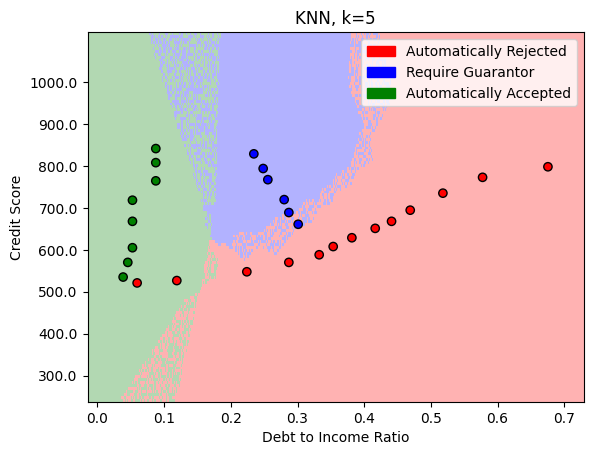

In [ ]:
# k=5
knn5 = KNNClassifier(10)
knn5.fit(X_applicants, y_applicants)
visualize_boundary(
    knn5,
    X_applicants,
    y_applicants,
    "KNN, k=5"
)

## Problem 3, Subpart 2

In [9]:
# Predicting for new applicant
point = transform(np.array([(0.32, 350)]))

# (a)
print("gaussian_shared prediction =", gaussian_shared.predict(point))

# (b)
print("gaussian_separate prediction =", gaussian_separate.predict(point))

# (c)
print("softmax prediction =", soft.predict(point))
print("softmax prediction probabilities =", soft.predict_proba(point))

# (d)
print("softmax2 prediction =", soft2.predict(phi(point)))
print("softmax2 prediction probabilities =", soft2.predict_proba(phi(point)))

# (e)
print("kNN (k=1) prediction =", knn1.predict(point))
print("kNN (k=5) prediction =", knn5.predict(point))

NameError: name 'gaussian_shared' is not defined